In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import itertools
from operator import itemgetter
import copy

# naive algo

/home/jaime/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:563: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
/home/jaime/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: 
The is_numlike function was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use isinstance(..., numbers.Number) instead.
  if cb.is_numlike(alpha):


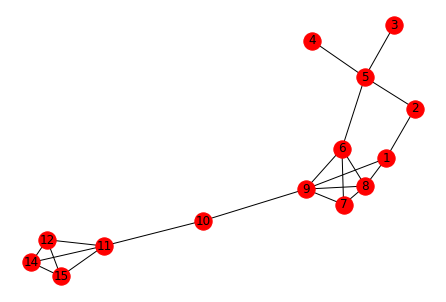

In [2]:
g = nx.Graph([])
g.add_edges_from([(1,2),(1,8),(1,9),
                  (5,2),
                  (5,3),
                  (5,4),
                  (5,6),
                  (6,7),
                  (6,8),
                  (6,9),
                  (7,8),
                  (7,9),
                  (8,9),
                  (9,10),
                  (10,11),
                  (11,14),
                  (11,15),
                  (11,12),
                  (14,15),
                  (15,12),
                  (12,14)
                 ])
nx.draw(g,with_labels=True)
plt.show()

In [3]:
def approche_naive(g):
    gg = copy.deepcopy(g)
    weights = dict(gg.degree)

    cores_g = dict(zip(gg.nodes,[0]*len(gg.nodes)))

    while len(gg.nodes) > 0:
        index_top , min_degree   = min(weights.items(), key=itemgetter(1))
        neighbors = list(gg.neighbors(index_top))
        cores_g[index_top] = min_degree
        gg.remove_node(index_top)
        weights.pop(index_top)

        if neighbors:
            new_degrees=gg.degree()
            for neigh in neighbors:
                weights[neigh] = max(min_degree,new_degrees[neigh])
                
    return cores_g

# Approach 1

In [5]:
def batagelj_naif(G):
    degrees = dict(G.degree())
    nodes = sorted(degrees, key=degrees.get)
    nbrs = {v: list(nx.all_neighbors(G, v)) for v in G}
    i=0
    count_passed_through = []
    while len(count_passed_through)<len(nodes):
        nodes = sorted(degrees, key=degrees.get)       
        st =  set(count_passed_through)
        v = [ele for ele in nodes if ele not in st][0]  ### check mainting order

        for u in nbrs[v]:
            if degrees[u] > degrees[v]:
                degrees[u] -= 1
                
        count_passed_through.append(v)

    return degrees

In [7]:
%load_ext Cython

In [8]:
%%cython
import networkx as nx
import matplotlib.pyplot as plt
import itertools
from operator import itemgetter
import copy

def batagelj_naif_cython(G):
    degrees = dict(G.degree())
    nodes = sorted(degrees, key=degrees.get)
    nbrs = {v: list(nx.all_neighbors(G, v)) for v in G}
    i=0
    count_passed_through = []
    while len(count_passed_through)<len(nodes):
        nodes = sorted(degrees, key=degrees.get)       
        st =  set(count_passed_through)
        v = [ele for ele in nodes if ele not in st][0]  ### check mainting order

        for u in nbrs[v]:
            if degrees[u] > degrees[v]:
                degrees[u] -= 1
                
        count_passed_through.append(v)

    return degrees

# Similaire nx

In [9]:
def batagelj_avance(G):
# inspiré, comme mentionné sur le rapport, du code source de NetworkX, (Hagberg, Schult, Swart)
    degrees = dict(G.degree())
    # Sort nodes by degree.
    nodes = sorted(degrees, key=degrees.get)
    bin_boundaries = [0]
    curr_degree = 0
    for i, v in enumerate(nodes):
        if degrees[v] > curr_degree:
            bin_boundaries.extend([i] * (degrees[v] - curr_degree))
            curr_degree = degrees[v]
    node_pos = {v: pos for pos, v in enumerate(nodes)}
    

    core = degrees
    nbrs = {v: list(nx.all_neighbors(G, v)) for v in G}
    for v in nodes:
        for u in nbrs[v]:
            if core[u] > core[v]:
                nbrs[u].remove(v)
                pos = node_pos[u]
                bin_start = bin_boundaries[core[u]]
                node_pos[u] = bin_start
                node_pos[nodes[bin_start]] = pos
                nodes[bin_start], nodes[pos] = nodes[pos], nodes[bin_start]
                bin_boundaries[core[u]] += 1
                core[u] -= 1
    return core

# sanity check

On teste que nos approches soient bonnes sur un nombre suffisament important et divers de graphes

In [18]:
G = nx.duplication_divergence_graph(10**3,0.7)
approche_naive(G) == batagelj_naif(G) == batagelj_avance(G) == nx.core_number(G)

True

In [20]:
G = nx.balanced_tree(5,3)
approche_naive(G) == batagelj_naif(G) == batagelj_avance(G) == nx.core_number(G)

True

In [21]:
G = nx.circular_ladder_graph(150)
approche_naive(G) == batagelj_naif(G) == batagelj_avance(G) == nx.core_number(G)

True

In [26]:
G = nx.generators.random_graphs.gnm_random_graph(150,200)
approche_naive(G) == batagelj_naif(G) == batagelj_avance(G) == nx.core_number(G)

True

# approach comparison

In [30]:
from timeit import timeit
array_len_range= range(2,1500,250)
functions = ['approche_naive','batagelj_naif','batagelj_avance','nx.core_number']
# labels = ['algorithme naif', 'batagelj basique', 'batagelj avancé', 'nx.core_number']
functions_arrays=[(i,[]) for i in functions]
x = [10*i for i in array_len_range]

for num,i in enumerate(x):
    num_iter = 4
    print(num)

    G = nx.duplication_divergence_graph(i,0.7)

    for function,array in functions_arrays:
        time = timeit(str(function + '(G)'), number=num_iter, globals=globals())/num_iter
        array.append(time)

0
1
2
3
4
5


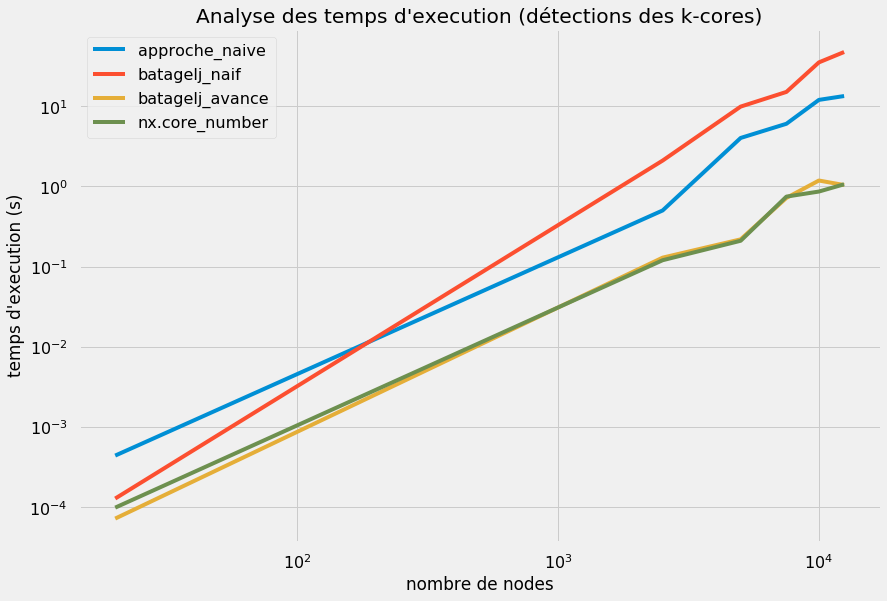

In [32]:

from matplotlib import pyplot as plt
import numpy as np


plt.style.use(['seaborn-poster','fivethirtyeight'])

# plt.style.use(['dark_background', 'presentation'])


fig, ax = plt.subplots()
for function,array in functions_arrays:
    ax.plot(x, array,label=function)

ax.set_title("Analyse des temps d'execution (détections des k-cores)")
ax.legend()
ax.set_yscale('log')
ax.set_xscale('log')

plt.xlabel ("nombre de nodes")
plt.ylabel ("temps d'execution (s)")
plt.show()